# Load Libraries and Functions

In [1]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
import multiprocessing
num_cores = multiprocessing.cpu_count()  # Define number of cores available
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns

# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Importing Custom Functions
import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years, examine_text_outliers
from Functions import process_company_text, clean_manufacturer_text


# API Keys and Passwords

In [2]:
# mysql password
PASSWORD = "schweini"

# openFDA API Key
"E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk"  # Halee

# Data.Medicaid API Key




'E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk'

In [3]:
# Code to assess performance
# Still need to implement
from line_profiler import LineProfiler

def your_function():
    # Your code here


    profiler.add_function(your_function)
profiler.run('your_function()')
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 0 s
File: /var/folders/9n/rvh416ss641f86jq46p9wy380000gn/T/ipykernel_1460/2062560860.py
Function: your_function at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def your_function():
     6                                               # Your code here
     7                                           
     8                                           
     9                                               profiler.add_function(your_function)



# FDA Data

## API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [4]:
# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    documents = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

        print(f".")

    return documents

# Fetch the data
documents = fetch_data(max_requests=1)

# Save the data to a CSV file
documents_df = pd.DataFrame(documents)
documents_df.head()

.


,doc_type,year,text
0,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
1,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
2,talk,1991,I FOOD _-AND DRUG ADMINISTRATION ‘ 'i\nU. S. D...
3,pr,1934,iNFORMATION FOR THE PRESS\n\nu 8. DEPARTMENT O...
4,pr,1975,\n\nU. S. DEPARTMENT OF HEALTH. EDUCATION. AN...


In [5]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  1000 non-null   object
 1   year      1000 non-null   int64 
 2   text      1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [6]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_documents.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(documents, json_file, indent=4)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [7]:
# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    events = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            events.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

        print(f".")

    return events

# Fetch the data
events = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
events_df = pd.json_normalize(events)

# Display the first few rows of the DataFrame
events_df.head()

.
.


,safetyreportid,transmissiondateformat,transmissiondate,serious,seriousnessdeath,receivedateformat,receivedate,receiptdateformat,receiptdate,fulfillexpeditecriteria,...,seriousnessother,occurcountry,patient.patientagegroup,seriousnesshospitalization,patient.summary.narrativeincludeclinical,seriousnesslifethreatening,patient.patientweight,primarysource.literaturereference,seriousnesscongenitalanomali,authoritynumb
0,5801206-7,102,20090109,1,1,102,20080707,102,20080625,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003300,102,20141002,1,NaN,102,20140306,102,20140306,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10003301,102,20141002,1,NaN,102,20140228,102,20140228,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003302,102,20141002,2,NaN,102,20140312,102,20140312,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10003304,102,20141212,2,NaN,102,20140312,102,20140424,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   safetyreportid                               2000 non-null   object 
 1   transmissiondateformat                       2000 non-null   object 
 2   transmissiondate                             2000 non-null   object 
 3   serious                                      2000 non-null   object 
 4   seriousnessdeath                             145 non-null    object 
 5   receivedateformat                            2000 non-null   object 
 6   receivedate                                  2000 non-null   object 
 7   receiptdateformat                            2000 non-null   object 
 8   receiptdate                                  2000 non-null   object 
 9   fulfillexpeditecriteria                      2000 non-null   object 
 10  

#### Examine Variables of Interest

In [9]:
# 2 - Yes, 1 - No
events_df['fulfillexpeditecriteria'].value_counts()

2    1131
1     869
Name: fulfillexpeditecriteria, dtype: int64

In [10]:
# 5 - Consumer/NonHealth, 4 - Lawyer, 3 - Health Professional, 4 - Pharmacist, 5 - MD
events_df['primarysource.qualification'].value_counts()

5    1084
1     412
3     288
4     151
2      57
Name: primarysource.qualification, dtype: int64

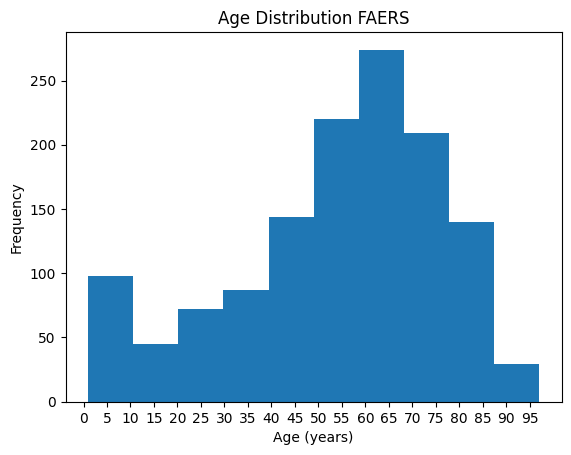

In [11]:
# Distribution of Age
plt.hist(events_df['patient.patientonsetage'].astype('float'))
ticks = np.arange(0, 100, 5)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution FAERS')
plt.show()

In [12]:
# Ages come in different units, need to standardize to years
events_df['patient.patientonsetageunit'].value_counts()

801    1313
804       4
802       1
Name: patient.patientonsetageunit, dtype: int64

In [13]:
# Some reports have more than one version, retain most recent versions only
events_df['safetyreportversion'].value_counts()

1     1040
2      556
3      337
4       37
5       10
6        6
7        6
8        3
9        2
11       1
12       1
Name: safetyreportversion, dtype: int64

In [14]:
# Can see manufacturers where most reports were duplicated
events_df['reportduplicate.duplicatesource'].value_counts()

GILEAD                  458
PFIZER                  320
MERCK                   175
INCYTE                  166
ABBVIE                  160
NOVARTIS                139
BAXTER                   82
GLAXOSMITHKLINE          75
TEVA                     51
BOEHRINGER INGELHEIM     47
BAYER                    45
SANDOZ                   32
CELGENE                  29
MYLAN                    29
JANSSEN                  20
LUNDBECK                 18
WATSON                   18
BRISTOL MYERS SQUIBB     15
AVENTIS                  11
GE HEALTHCARE            11
AMGEN                    11
ACTAVIS                   8
ASTRAZENECA               7
ALEXION                   7
ROCHE                     6
ACTELION                  6
EMD SERONO INC            6
ACORDA                    6
FOREST                    6
PURDUE                    4
VERTEX                    4
OTSUKA                    3
CUBIST                    3
ETHICON                   3
PHARMACYCLICS             2
JOHNSON AND JOHNSON 

In [ ]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_events.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(events, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [15]:
# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    labels = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            labels.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()
        
        print(f".")

    return labels

# Fetch the data
labels = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
labels_df = pd.json_normalize(labels)

# Display the first few rows of the DataFrame
labels_df.head()

.
.


,effective_time,inactive_ingredient,purpose,keep_out_of_reach_of_children,warnings,questions,spl_product_data_elements,version,dosage_and_administration,pregnancy_or_breast_feeding,...,components,intended_use_of_the_device,mechanism_of_action_table,general_precautions_table,drug_and_or_laboratory_test_interactions_table,accessories,ask_doctor_table,when_using_table,ask_doctor_or_pharmacist_table,do_not_use_table
0,20210902,[INACTIVE INGREDIENTS Sucrose],"[USES USES: Temporary Relief - Acne, Boils* * ...",[Keep this and all medication out of reach of ...,[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,2,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...","[As with any drug, if you are pregnant, or nur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Purpose Sunscreen],[Keep out of reach of children If product is s...,[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,4,[Directions Protection Naturelle SPF 46 PA+++ ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802,[INACTIVE INGREDIENTS Sucrose/Lactose],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,3,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230905,NaN,NaN,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,NaN,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,7,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230403,NaN,NaN,NaN,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,27,[2 DOSAGE AND ADMINISTRATION Use the lowest ef...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pd.set_option('display.max_info_columns', 140)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 140 columns):
 #    Column                                                            Non-Null Count  Dtype 
---   ------                                                            --------------  ----- 
 0    effective_time                                                    2000 non-null   object
 1    inactive_ingredient                                               1218 non-null   object
 2    purpose                                                           1190 non-null   object
 3    keep_out_of_reach_of_children                                     1186 non-null   object
 4    warnings                                                          1584 non-null   object
 5    questions                                                         659 non-null    object
 6    spl_product_data_elements                                         1999 non-null   object
 7    version                        

In [17]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_labels.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(labels, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Manufacturer Information (NDC)

In [18]:
# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/ndc.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    manus = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            manus.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()
        
        print(f".")

    return manus

# Fetch the data
manus = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
manus_df = pd.json_normalize(manus)

# Display the first few rows of the DataFrame
manus_df.head()

.
.


,product_ndc,generic_name,labeler_name,brand_name,active_ingredients,finished,packaging,listing_expiration_date,marketing_category,dosage_form,...,openfda.nui,openfda.pharm_class_moa,openfda.pharm_class_cs,openfda.pharm_class_epc,openfda.unii,dea_schedule,openfda.is_original_packager,openfda.pharm_class_pe,marketing_end_date,brand_name_suffix
0,72789-186,Ibuprofen,"PD-Rx Pharmaceuticals, Inc.",Ibuprofen,"[{'name': 'IBUPROFEN', 'strength': '800 mg/1'}]",True,"[{'package_ndc': '72789-186-30', 'description'...",20251231,ANDA,"TABLET, FILM COATED",...,"[N0000000160, M0001335, N0000175722]",[Cyclooxygenase Inhibitors [MoA]],"[Anti-Inflammatory Agents, Non-Steroidal [CS]]",[Nonsteroidal Anti-inflammatory Drug [EPC]],[WK2XYI10QM],NaN,NaN,NaN,NaN,NaN
1,72789-418,Amoxicillin and Clavulanate Potassium,"PD-Rx Pharmaceuticals, Inc.",Amoxicillin and Clavulanate Potassium,"[{'name': 'AMOXICILLIN', 'strength': '500 mg/1...",True,"[{'package_ndc': '72789-418-14', 'description'...",20251231,ANDA,"TABLET, FILM COATED",...,NaN,NaN,NaN,NaN,"[804826J2HU, Q42OMW3AT8]",NaN,NaN,NaN,NaN,NaN
2,72865-130,OXYMORPHONE HYDROCHLORIDE,"XLCare Pharmaceuticals, Inc.",OXYMORPHONE HYDROCHLORIDE,"[{'name': 'OXYMORPHONE HYDROCHLORIDE', 'streng...",True,"[{'package_ndc': '72865-130-01', 'description'...",20241231,ANDA,TABLET,...,NaN,NaN,NaN,NaN,[5Y2EI94NBC],CII,[True],NaN,NaN,NaN
3,72888-106,carbidopa and levodopa,"Advagen Pharma Ltd.,",Carbidopa-levodopa,"[{'name': 'CARBIDOPA', 'strength': '10 mg/1'},...",True,"[{'package_ndc': '72888-106-00', 'description'...",20241231,ANDA,TABLET,...,"[N0000193220, M0370111, N0000175754, N0000175755]",[DOPA Decarboxylase Inhibitors [MoA]],"[Amino Acids, Aromatic [CS]]","[Aromatic Amino Acid [EPC], Aromatic Amino Aci...","[46627O600J, MNX7R8C5VO]",NaN,[True],NaN,NaN,NaN
4,73025-169,ALCOHOL,Shalom International Corp,Spatherapy Antibacterial French Lavender,"[{'name': 'ALCOHOL', 'strength': '62 mL/100mL'}]",True,"[{'package_ndc': '73025-169-00', 'description'...",20241231,OTC MONOGRAPH DRUG,GEL,...,NaN,NaN,NaN,NaN,[3K9958V90M],NaN,[True],NaN,NaN,NaN


In [19]:
pd.set_option('display.max_info_columns', 40)
manus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   product_ndc                   2000 non-null   object
 1   generic_name                  2000 non-null   object
 2   labeler_name                  2000 non-null   object
 3   brand_name                    1690 non-null   object
 4   active_ingredients            1962 non-null   object
 5   finished                      2000 non-null   bool  
 6   packaging                     2000 non-null   object
 7   listing_expiration_date       1947 non-null   object
 8   marketing_category            2000 non-null   object
 9   dosage_form                   2000 non-null   object
 10  spl_id                        2000 non-null   object
 11  product_type                  2000 non-null   object
 12  route                         1661 non-null   object
 13  marketing_start_da

# National Library of Medicine - Standardized Drug Names and Information

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [20]:
# Base URL for RxTerms API to get all drug names
#BASE_URL = 'https://rxnav.nlm.nih.gov/REST/RxTerms/rxcui'

# Function to pause execution to avoid overwhelming the server
#def pause_execution():
#    time.sleep(1 + 2 * random.random())

# Function to fetch data from the RxTerms API
#def fetch_data(max_requests):
#    drugs = []
#    start_rxcui = 1  # Starting RxCUI for the search
#    step = 500      # Step size to iterate through RxCUIs
#    request_count = 0  # Initialize request counter

#    while request_count < max_requests:
#        batch_drugs = []
#        for i in range(start_rxcui, start_rxcui + step):
#            url = f"{BASE_URL}/{i}/allinfo.json"
#            response = requests.get(url)

#            if response.status_code != 200:
#                print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
#                continue

#            if response.content.strip():  # Check if the response content is not empty
#                data = response.json()
#                properties = data.get('rxtermsProperties', {})

#                if properties:
#                    if properties.get('marketed', '').lower() == 'true':
#                        properties['rxcui'] = i
#                        batch_drugs.append(properties)

#        drugs.extend(batch_drugs)  # Add the batch results to the main list
#        print(f"Processed batch starting with RxCUI: {start_rxcui}")  # Debugging statement for each batch

        # Update the start_rxcui for the next batch
 #       start_rxcui += step
#      request_count += 1  # Increment request counter

        # Break condition to stop if no more data in the batch
#        if not batch_drugs:
#            break

#        pause_execution()

#    return drugs

# Fetch the data
#drugs = fetch_data(max_requests=1)

# Convert the data to a pandas DataFrame
#drugs_df = pd.DataFrame(drugs)

# Display the first few rows of the DataFrame
#drugs_df.head()

In [21]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [22]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [23]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


In [24]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

((2601, 8), (15317, 5))

# Medicaid 

## API Drug Prices - NADAC - 2024 Report 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [25]:
# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time between 1 and 3 seconds to avoid hitting the server too hard
    time.sleep(1 + 2 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    max_requests = 2  # Maximum number of requests to fetch 1000 records
    
    for _ in range(max_requests):  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        #print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        #print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            #print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
            print(f".")
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()
#print(f"Total records fetched: {len(prices_df)}")  # Debugging statement

.
.


,NDC Description,NDC,NADAC_Per_Unit,Effective Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78326,2022-12-21,ML,C/I,Y,"1, 5",G,,,2023-01-04
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04


In [26]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   NDC Description                            1000 non-null   object
 1   NDC                                        1000 non-null   object
 2   NADAC_Per_Unit                             1000 non-null   object
 3   Effective Date                             1000 non-null   object
 4   Pricing_Unit                               1000 non-null   object
 5   Pharmacy_Type_Indicator                    1000 non-null   object
 6   OTC                                        1000 non-null   object
 7   Explanation_Code                           1000 non-null   object
 8   Classification_for_Rate_Setting            1000 non-null   object
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  1000 non-null   object
 10  Corresponding_Generic_Drug_Effective_

In [27]:
prices_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78326,2022-12-21,ML,C/I,Y,"1, 5",G,,,2023-01-04
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04


# Preprocessing

## PreProcess Labels Table

#### Select Columns

In [28]:
labels_table = pd.DataFrame(labels_df, 
                            columns = ["effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [29]:
labels_table.head()

,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,20210902,"[USES USES: Temporary Relief - Acne, Boils* * ...",[WARNINGS This product is to be used for self-...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,[SILICEA],[SILICEA],"[Rxhomeo Private Limited d.b.a. Rxhomeo, Inc]",[SILICON DIOXIDE],[15631-0404],NaN,NaN,NaN
1,20150109,[Purpose Sunscreen],[Warnings For external use only.],[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802,[USES To relieve the symptoms of itching.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230905,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,NaN,NaN,NaN,NaN,NaN,NaN,[CONTRAINDICATIONS Ofloxacin ophthalmic soluti...,[PRECAUTIONS General: As with other anti-infec...
4,20230403,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,[Naproxen],[NAPROXEN],[A-S Medication Solutions],[NAPROXEN],[50090-0481],[198014],[4 CONTRAINDICATIONS Naproxen tablets and napr...,NaN


## LIST OF UNIQUE DRUG NAMES

will move functions into functions later

In [30]:
import pandas as pd

# drugs are currently in list format, clean to work with
def clean_data(column):
    cleaned_column = column.apply(lambda x: ','.join(x) if isinstance(x, list) else x)
    return cleaned_column

# match text
def contains_unique_value(text, unique_values_lower):
    matched_texts = []
    text_lower = text.lower()
    for value in unique_values_lower:
        if value in text_lower:
            matched_texts.append(value)
    return matched_texts

# use clean_data function to join list together
labels_table['openfda.brand_name'] = clean_data(labels_table['openfda.brand_name'])
labels_table['openfda.generic_name'] = clean_data(labels_table['openfda.generic_name'])

# extract unique list values
unique_brand_names = labels_table['openfda.brand_name'].dropna().unique()
unique_generic_names = labels_table['openfda.generic_name'].dropna().unique()

# combine the brand and generic columns to account for all possibl enames
unique_drug_names = set(unique_brand_names).union(set(unique_generic_names))

# convert to lowercase, could probably just add to clean data function
unique_drug_names = [str(value).lower() for value in unique_drug_names]

In [ ]:
# Incorporate parallel processing - need to finish
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    result['var'] = p.map(clean_data, labels_table['openfda.brand_name'])

Process SpawnPoolWorker-10:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'clean_data' on <module '__main__' (built-in)>
Process SpawnPoolWorker-12:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anacon

### Examine Nulls

In [32]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,effective_time,0,0.00
1,purpose,810,40.50
2,warnings,416,20.80
3,spl_product_data_elements,1,0.05
4,openfda.brand_name,1021,51.05
5,openfda.generic_name,1021,51.05
6,openfda.manufacturer_name,1021,51.05
7,openfda.substance_name,1031,51.55
8,openfda.product_ndc,1021,51.05
9,openfda.rxcui,1268,63.40


### Fix Dtypes

In [ ]:
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

### Process Text Columns

<span style="background-color:yellow">**Delete below chunk after multiprocessing works. Kept original for now to avoid errors**</span>


In [ ]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'openfda.product_ndc', 'openfda.rxcui'], errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

In [ ]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'openfda.product_ndc', 'openfda.rxcui'], errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
with multiprocessing.Pool(num_cores) as p:
    for col in object_columns:
        new_col_name = col + '_processed'
    # Incorporate parallel processing - need to finish
    # Create a pool with the same number of workers as CPU cores
        labels_table[new_col_name] = p.map(process_label_text, labels_table[col])

### Examine all variables for quality, content, and redundancy

In [ ]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [ ]:
#labels_table['purpose'].head()

In [ ]:
#labels_table['purpose_processed'].info()

In [ ]:
#labels_table['purpose_processed'].head(5)

In [ ]:
#labels_table['warnings'].head()

In [ ]:
#labels_table['warnings_processed'].head()

In [ ]:
#labels_table['contraindications'].head()

In [ ]:
#labels_table['contraindications_processed'].head()

In [ ]:
#labels_table['precautions'].head()

In [ ]:
#labels_table['precautions_processed'].head()

In [ ]:
#labels_table['openfda.brand_name_processed'].head()

In [ ]:
#labels_table['openfda.generic_name_processed'].head()

In [ ]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [ ]:
#labels_table['openfda.product_type_processed'].head()

In [ ]:
#labels_table['openfda.substance_name_processed'].head()

In [ ]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [ ]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)

### Final List of Features for Labels Data

In [ ]:
labels_table.columns

In [ ]:
labels_table = labels_table[['label_id', 
                             'openfda.product_ndc',
                             'openfda.rxcui',
                             'effective_time',
                            'spl_product_data_elements_processed', 
                             'all_warnings_processed', 
                             'all_name_processed', 
                            'purpose_processed']]

In [ ]:
labels_table.head(2)

### Assess Text Field Lengths

In [ ]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

### Rename Columns

In [ ]:
labels_table = labels_table.rename(columns = {'openfda.product_ndc': 'ndc',
                                              'openfda.rxcui': 'rxcui',
                         'effective_time': 'label_date',
                         'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'all_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [ ]:
labels_table.info()

In [ ]:
# Write the DataFrame to a CSV file
labels_table.to_csv('DataLibrary/labels_table.csv', index=False)

## PreProcess Events Table

#### Select Columns

In [ ]:
events_table = pd.DataFrame(events_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        #"seriousnessdeath", # 1 = death, redundant with serious
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug", # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      ])

In [ ]:
events_table.head(1)

#### Fix Dtypes

In [ ]:
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')
events_table['serious'] = events_table['serious'].astype(int)
events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())

events_table.info()

### Standardize Age

In [ ]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(1)

### Feature Engineering

In [ ]:
# Serious prior to mapping
events_table['serious'].value_counts()

In [ ]:
events_table = add_sequential_index(events_table,'event_id')

# Save 1 as death, life threatening, hospitalization, disability, congenital anomaly, or serious condition, 0 as not that
events_table['serious'] = events_table['serious'].replace({1: 1, 2: 0})

In [ ]:
# Serious post-mapping
events_table['serious'].value_counts()

### Check for Report Duplicates

In [ ]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

### Examine and Handle Nulls

In [ ]:
events_nan = nan_info(events_table)
events_nan

In [ ]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports
* Verify that API called only most recent version of reports

In [ ]:
# Drop NaN values in 'primarysource.qualification'
events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

events_table.shape

In [ ]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

### Rename Columns

In [ ]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.patientonsetage': 'age',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    'transmissiondate': 'event_date',
    'fulfillexpeditecriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

In [ ]:
#pd.reset_option('display.max_colwidth')
events_table.head()

### Examine Variables in Reaction Nested Dataframe - Multiple Reaction Reports for Each Symptom for Each Person

In [ ]:
test_record = events_table['reaction'].loc[events_table['event_id'] == 2000]
# Patient Reaction is an array containing:
    # reactionmeddrapt: Patient reaction, as a MedDRA term. 
    # reactionmeddraversionpt: The version of MedDRA from which the term in reactionmeddrapt is drawn.
    # reactionoutcome: Outcome of the reaction in reactionmeddrapt at the time of last observation.
        # 1= Recovered/resolved, 2=recovering/resolving, 3 = Not recovered/not resolved, 4=Recovered/resolved with consequent health issues
        # 5 = fatal, 6 = Unknown

# First, want to individualzie these fields. Will actually save these as a NEW table, called PatientReactions

In [ ]:
# Set pandas option to display full content of columns
print(test_record)

### Make new table for PatientDrugs - nested dataframe

In [ ]:
expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_df = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_df = patient_drugs_df[['event_id'] + [col for col in patient_drugs_df.columns if col != 'event_id']]


patient_drugs_df.tail()

#### Parallel Processing Version - need to test - can move function to other file

<span style="background-color:yellow">**Delete below chunk after multiprocessing complete**</span>


In [ ]:
expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]


patient_drugs_table.tail()

In [ ]:
# Function to process each row
def process_row(row):
    expanded_entries = []
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_entries.append(flattened_entry)
    
    return expanded_entries

# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    expanded_patient_drugs = p.map(process_row, [row for _, row in events_table.iterrows()])

# Flatten the list of lists
expanded_patient_drugs = [item for sublist in expanded_patient_drugs for item in sublist]

# Concatenate all entries into a new DataFrame
patient_drugs_df = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_df = patient_drugs_df[['event_id'] + [col for col in patient_drugs_df.columns if col != 'event_id']]

patient_drugs_df.tail()

### Make new table for PatientReactions

In [ ]:
expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]
patient_reactions_df.tail()

#### Parallel Processing Version - need to test - can move function to other file

In [ ]:
# Function to process each row
def process_reaction_row(row):
    expanded_entries = []
    event_id = row['event_id']
    
    # Iterate through each reaction entry in 'reaction' list
    for reaction_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(reaction_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_entries.append(flattened_entry)
    
    return expanded_entries

# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    expanded_patient_reaction = p.map(process_reaction_row, [row for _, row in events_table.iterrows()])

# Flatten the list of lists
expanded_patient_reaction = [item for sublist in expanded_patient_reaction for item in sublist]

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]

patient_reactions_df.tail()

### Remove Drug and Reaction Columns as they are in new tables

In [ ]:
events_table.drop(['drug', 'reaction'], axis=1, inplace=True)

### Assess Text Field Lengths

In [ ]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [ ]:
events_table_text_processed_outliers = examine_text_outliers(events_table['company'])
print(events_table_text_processed_outliers.iloc[2])

#### Custom Text Processing of Company Information - Retain Name Only

In [ ]:
# Creat list of country abbreviations and extra abbreviations to remove from text data
country_codes = events_table['country'].unique().tolist()
country_codes = [i.lower() for i in country_codes]
country_codes = ['cn' if country == 'canada' else country for country in country_codes]
country_codes = country_codes+["usa", "isr", "ger", "tus", "dklu", "bp", "sp",
                                  "nj", "aus", "deuct", "ve", "pomal", "gbr",
                                  "jacan", "fra", "deu", 'deuct']

extra_abv = ['nldsp', 'usasp', 'company', 'bax', 'spo',
                'ccaza', 'cinry']

country_codes.to_csv('country_codes.csv', index=False)


In [ ]:
events_table.head()

In [ ]:
from Functions import process_company_text
events_table['company_name'] = events_table['company'].apply(process_company_text)

In [ ]:
events_table.head()

In [ ]:
# Need to test
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    # Apply the process_company_row function to each element in the 'company' column in parallel
    events_table['company_name'] = p.map(process_company_text, events_table['company'])

In [ ]:
events_table[['company', 'company_name', 'country']].head(20) 

In [ ]:
# Set display option to show the full list without truncation
pd.set_option('display.max_rows', None)
events_table['company_name'].value_counts()
# Reset display option to default
#pd.reset_option('display.max_rows')

#### Text Processing of Country Name

In [ ]:
# Replace category missing label with NA and Canada
events_table['country'] = events_table['country'].replace({"COUNTRY NOT SPECIFIED": pd.NA, "CANADA": 'CN'})

# Lower case country code text
events_table['country'] = events_table['country'].apply(lambda x: x.lower() if pd.notna(x) else x)

In [ ]:
events_table['country'].head(20)

In [ ]:
# Drop Cryptic company information
events_table.drop(['company'], axis = 1, inplace = True)

In [ ]:
events_table[['company_name', 'country']].head(10) 

### Reeaxmine Field Lengths

In [ ]:
plot_character_length(events_table, 'events_table')

In [ ]:
examine_text_outliers(events_table['company_name'])

In [ ]:
# Write the DataFrame to a CSV file
events_table.to_csv('DataLibrary/events_table.csv', index=False)

## PreProcess Patient Drugs Table

In [ ]:
patient_drugs_df.head()

patient_drugs_df.columns

#### Select Columns

In [ ]:
patient_drugs_table = pd.DataFrame(patient_drugs_df, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                #'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                # 'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [ ]:
patient_drugs_table.head(5)

#### Fix Dtypes

In [ ]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [ ]:
patient_drugs_table['drugcharacterization'].value_counts()

In [ ]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [ ]:
patient_drugs_table['drugcharacterization'].value_counts()

### Examine Nulls

In [ ]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

### Text Processing

In [ ]:
# Apply the clean_text function
patient_drugs_table['manu_list'] = patient_drugs_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)

In [ ]:
# Need to test
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    patient_drugs_table['manu_list'] = p.map(clean_manufacturer_text, patient_drugs_table['openfda.manufacturer_name'])

In [ ]:
# Count the number of manufacturers that produce the drug
patient_drugs_table['manu_num'] = patient_drugs_table['manu_list'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [ ]:
# Count the number of rxcui associated with drug
patient_drugs_table['rxcui_num'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [ ]:
patient_drugs_table[['openfda.manufacturer_name', 'manu_list', 'manu_num', 'rxcui_num']].head(10)

In [ ]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 'openfda.rxcui', 'openfda.manufacturer_name', 'manu_list'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    for col in object_columns:
        new_col_name = col + '_processed'
        # Apply the process_column function to each column in parallel
        patient_drugs_table[new_col_name] = p.map(process_label_text, patient_drugs_table[col])

### Final list of features for Patient Drugs Table

In [ ]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                          #'drugcharacterization',  # Not necessary since table is filtered to value of 1 for all
                                          'drugindication_processed',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'manu_list',
                                          'manu_num',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                           'rxcui_num',
                                          'openfda.unii'
                                          ]]

### Rename Columns

In [ ]:
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct_processed': 'med_product',
    'drugindication_processed': 'indication',
    'openfda.generic_name_processed': 'generic_name',
    'manu_list': 'manufacturers',
    'openfda.product_type_processed': 'product_type',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii'
})

In [ ]:
patient_drugs_table.info()

### Assess Text Field Lengths

In [ ]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

**Examine 'Manufacturer' Outliers**
Reports contain manufacturers, distributors, and retail

In [ ]:
patient_drugs_table_manufacturer_outliers = examine_text_outliers(patient_drugs_table['manufacturers'])
print(patient_drugs_table_manufacturer_outliers.iloc[2])

**Examine 'rxcui' outliers**

In [ ]:
patient_drugs_table_rxcui_outliers = examine_text_outliers(patient_drugs_table['rxcui'])
print(patient_drugs_table_rxcui_outliers.iloc[1])

In [ ]:
# Write the DataFrame to a CSV file
patient_drugs_table.to_csv('DataLibrary/drugs_table.csv', index=False)

## PreProcess Patient Reactions Table

### Rename Columns

In [ ]:
patient_reactions_table = patient_reactions_df.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [ ]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [ ]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

### Map Features

In [ ]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered',
    2: 'Recovering',
    3: 'NotRecovered',
    4: 'RecoveredWithSequelae',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

## LIST OF UNIQUE REACTIONS

In [ ]:
# Get unique values from the 'reaction' column
unique_reactions = patient_reactions_table['reaction'].unique().tolist()
unique_reactions = [reaction.lower() for reaction in unique_reactions]

# Display unique values
print(unique_reactions)

### Text Processing

In [ ]:
#patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

In [ ]:
# Need to test
with multiprocessing.Pool(num_cores) as p:
    # Apply the process_reaction function to each element in the 'reaction' column in parallel
    patient_reactions_table['reaction_processed'] = p.map(process_reaction, patient_reactions_table['reaction'])

patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [ ]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


### Filter for Data Quality

In [ ]:
# Drop cases with "unknown" outcomes
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['outcome'] != 'Unknown']

### Assess Text Field Lengths

In [ ]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [ ]:
# Write the DataFrame to a CSV file
patient_reactions_table.to_csv('DataLibrary/reactions_table.csv', index=False)

## PreProcess Prices Table

### Select Columns

In [ ]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        #"Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        #"Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


### Fix Dtypes

In [ ]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

### Examine Nulls

In [ ]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

### Feature Engineering 

In [ ]:
prices_table['Classification_for_Rate_Setting'].value_counts()

In [ ]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [ ]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')

### Rename Columns

In [ ]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [ ]:
prices_table.info()

In [ ]:
# Write the DataFrame to a CSV file
prices_table.to_csv('DataLibrary/prices_table.csv', index=False)

## Preprocess Documents Table

### Select Columns

In [ ]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')


### Fix Dtypes

### Match Drugs Present in Text

In [ ]:
def find_matching_drugs(text, unique_drug_names):
    matched_drugs = []
    for drug in unique_drug_names:
        if drug.lower() in text.lower():
            matched_drugs.append(drug)
    return matched_drugs

# Create 'matching_drugs' column using apply
documents_table['matching_drugs'] = documents_table['text'].apply(lambda x: find_matching_drugs(x, unique_drug_names))


In [ ]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    # Apply the process_document function to each element in the 'text' column in parallel
    documents_table['matching_drugs'] = p.map(find_matching_drugs, (documents_table['text'], unique_drug_names))



### Match Reactions Present in Text

In [ ]:
# Function to check for matches between text and unique_reactions
def check_reactions(text, unique_reactions):
    text_lower = text.lower()
    matches = [1 if reaction.lower() in text_lower else 0 for reaction in unique_reactions]
    return matches



In [ ]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores
with multiprocessing.Pool(num_cores) as p:
    # Apply the process_document function to each element in the 'text' column in parallel
    documents_table['matching_reactions'] = p.map(check_reactions, (documents_table['text'], unique_reaction_names))


### Generate binary column for each reaction

In [ ]:
# Apply the function across the dataframe to populate binary columns
documents_table[unique_reactions] = documents_table['text'].apply(lambda x: pd.Series(check_reactions(x, unique_reactions)))

# Text column no longer needed
documents_table.drop(columns=['text'], inplace=True)

# Function to return matching reactions as a list
def get_matching_reactions(row, unique_reactions):
    matching_reactions = [reaction for reaction in unique_reactions if row[reaction] == 1]
    return matching_reactions

# Create 'all_reactions' column by applying the function row-wise
documents_table['all_reactions'] = documents_table.apply(lambda row: get_matching_reactions(row, unique_reactions), axis=1)

documents_table.head()

In [ ]:
# apply parallel processing

### Explode Table by Reaction 

In [ ]:
# Explode the dataframe based on reaction; makes a new row for each reaction in the list
documents_table = documents_table.explode('matching_drugs').reset_index(drop=True)

### Rename columns

In [ ]:
documents_table.rename(columns={'matching_drugs': 'drug'}, inplace=True)

### Fix Dtypes

In [ ]:
numeric_columns = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug', 'all_reactions'])
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN

### Save as CSV for Data Exploration

In [ ]:
documents_table.to_csv('documents_table.csv', index=False)


## Preprocess Manufacturers Table

In [ ]:
manus_df.columns

In [ ]:
manus_df.info()

### Select Columns

In [ ]:
# Choose values to help fill in missing data from other tables
manus_table = pd.DataFrame(manus_df, 
                           columns=["product_ndc",
                                    "generic_name",
                                    "brand_name",
                                    "labeler_name",
                                    "openfda.manufacturer_name"])

### Feature Engineering

In [ ]:
manus_table = add_sequential_index(manus_table,'manu_id')

### Examine Nulls

In [ ]:
manus_nan = nan_info(manus_table)
manus_nan

### Fix Dtypes

### Text Processing

In [ ]:
# apply parallel processing

### Rename Columns

### Assess Text Field Lenghts

In [ ]:
# save .csv for EDA for now

# Standardization and Normalization
* Use Parallel Processing

## Read in ADReCS Files

In [ ]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

In [ ]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

### Clean Text into Tokens with Bigrams

### Create Mapping Dictionaries

## Standardize Drug Names into Primary Ingredient Compounds

## Standardize Adverse Event Terms

## Standardize Manufacturer Names

In [ ]:
# create custom compiled list and do string matching at 80% to standardize with NDC data

# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [ ]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [ ]:
# public username and password

### Create Edit Privelages for Us

In [ ]:
# private username and password

## Create dataframes from API request dataframes

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

# Create documents table
create_documents_table_query = """
CREATE TABLE IF NOT EXISTS `documents` (
  `doc_id` INT NOT NULL,
  `doc_type` VARCHAR(4),
  `doc_year` INT(4),
  `doc_text` VARCHAR(50000),
  PRIMARY KEY(`doc_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_documents_table_query)

# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT NOT NULL,
  `safetyreportid` VARCHAR(9),
  `event_date` DATE,
  `serious` BOOLEAN,
  `expedited` BOOLEAN,
  `report_source` INT,
  `company` VARCHAR(60),
  `country` VARCHAR(25),
  `sex` INT,
  PRIMARY KEY (`event_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table
create_patient_reactions_query = """
CREATE TABLE IF NOT EXISTS `patient_reactions` (
 `patient_reaction_id` INT NOT NULL,
  `event_id` INT,
  `reaction_processed` VARCHAR(100),
  `version_medRNA` VARCHAR(4),
  `outcome` VARCHAR(50),
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_reactions_query)

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `rxcui` VARCHAR(700),
  `ndc` VARCHAR(700), 
  `label_date` DATE,
  `ingredients` VARCHAR(3000),
  `warnings` VARCHAR(1000),
  `manufacturer` VARCHAR(1000),
  `drug_names` VARCHAR(2600),
  `purpose` VARCHAR(900),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(100),
  `indication` VARCHAR(60),
  `generic_name` VARCHAR(110),
  `manufacturer` VARCHAR(9000),
  `product_type` VARCHAR(50),
  `rxcui` VARCHAR(700),
  `unii` VARCHAR(130),
  PRIMARY KEY(`patient_drug_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
    ON DELETE CASCADE,
  INDEX(`event_id`),
  INDEX(`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `generic_price` VARCHAR(20),
  `generic_date` DATE,
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

## Bulk Import Data from Dataframes

### Documents Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
documents_list = documents_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO documents 
    (`doc_id`, `doc_type`, `doc_year`, `doc_text`) 
    VALUES (%s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, documents_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Events Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
events_list = events_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO adverse_events 
    (`event_id`, `safetyreportid`, `event_date`, 
    `serious`, `expedited`, `report_source`,
    `company`, `country`, `age`, `sex`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, events_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Patient Drugs Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
drugs_list = patient_drugs_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO patient_drugs
    (`patient_drug_id`, `event_id`, `med_product`, 
    `indication`, `generic_name`, `manufacturer`,
    `product_type`, `rxcui`, `unii`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, drugs_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Patient Reactions Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
reactions_list = patient_reactions_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO patient_reactions
    (`patient_reaction_id`, `event_id`, `version_meDRA`, 
    `outcome`, `reaction_processed`) 
    VALUES (%s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, reactions_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Labels Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
labels_list = labels_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO labels
    (`label_id`, `ndc`, `label_date`, 
    `ingredients`, `warnings`, `drug_names`,
    `manufacturer`, `purpose`, `rxcui`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, labels_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Prices Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
prices_list = prices_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO prices
    (`price_id`, `ndc`, `unit_price`, 
    `price_date`, `generic_brand`, `generic_price`,
    `generic_date`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, prices_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()